### Dataset

You can get the data set from the following URL: https://drive.google.com/drive/folders/1ZzDqVRtoNLrDHOB0lmbBwCVkpEZTl3FV?usp=share_link



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from audioop import bias
import sys
import os
import numpy as np
import pandas as pd
np.random.seed(50)
NUM_FEATS = 90

## Neural Network

In [2]:
class Net(object):
	def __init__(self, num_layers, num_units):
		self.num_layers = num_layers
		self.num_units = num_units

		self.biases = []
		self.weights = []
		for i in range(num_layers):

			if i==0:
				# Input layer
				self.weights.append(np.random.uniform(-1, 1, size=(NUM_FEATS, self.num_units)))
			else:
				# Hidden layer
				self.weights.append(np.random.uniform(-1, 1, size=(self.num_units, self.num_units)))

			self.biases.append(np.random.uniform(-1, 1, size=(self.num_units, 1)))

		# Output layer
		self.biases.append(np.random.uniform(-1, 1, size=(1, 1)))
		self.weights.append(np.random.uniform(-1, 1, size=(self.num_units, 1)))

	def __call__(self, X):
		a = X
		self.net = []
		self.O = []
		h = []
		self.net.append(a)
		for i,(w,b) in enumerate(zip(self.weights,self.biases)):
			self.O.append(a)
			h = np.dot(a,w)+b.T
			self.net.append(h)
			if i<len(self.weights)-1:
				a = relu(h)
			else:
				a = sigmoid(h)
		self.pred = a
		return self.pred

	def backward(self, X, y, lamda):
		delta_weights = []
		delta_biases = []

		back_outs = []
		back_act_outs = []

		loss = (self.pred - y)
		batch_size = y.shape[0]
		cur_layer = self.num_layers - 1

		back_outs.insert(0, loss)
		back_act_outs.insert(0, loss)
		delta_weights.insert(0, (np.dot(self.O[cur_layer+1].T, back_outs[0])/batch_size)+lamda * self.weights[cur_layer+1])
		delta_biases.insert(0, (np.array(np.sum(back_outs[0], axis=0).T))/batch_size )
		delta_biases[0] = delta_biases[0].reshape(delta_biases[0].shape[0], 1)
		delta_biases[0] = delta_biases[0] + lamda * self.biases[cur_layer+1]

		for i in range(1, self.num_layers + 1):
			back_act_outs.insert(0, np.dot(back_outs[0], self.weights[cur_layer + 1].T))
			back_outs.insert(0, back_act_outs[0] * d_relu(self.O[cur_layer + 1]))
			delta_weights.insert(0, (np.dot(self.O[cur_layer].T, back_outs[0])/batch_size)+lamda * self.weights[cur_layer])
			delta_biases.insert(0, (np.array(np.sum(back_outs[0], axis=0).T))/batch_size )
			delta_biases[0] = delta_biases[0].reshape(delta_biases[0].shape[0], 1)
			delta_biases[0] = delta_biases[0] + lamda * self.biases[cur_layer]
			cur_layer = cur_layer - 1
		
		return delta_weights, delta_biases

#### Optimizer Class

In [3]:
class Optimizer(object):
	def __init__(self, learning_rate):
		self.learning_rate = learning_rate

	def step(self, weights, biases, delta_weights, delta_biases):
		for index in range(len(weights)):
			weights[index] = weights[index] - self.learning_rate * delta_weights[index]
			biases[index] = biases[index] - self.learning_rate * delta_biases[index]
		
		return weights, biases

#### Loss functions

In [4]:
def loss_mse(y, y_hat):
	return np.sum((y-y_hat)**2)/len(y)

def loss_regularization(weights, biases):
	loss = 0
	for i in range(len(weights)):
		loss = loss + np.sum(np.square(weights[i])) + np.sum(np.square(biases[i]))
	return loss

def loss_fn(y, y_hat, weights, biases, lamda):
	return loss_mse(y,y_hat) + (lamda * loss_regularization(weights, biases))

def rmse(y, y_hat):
	#root[sum[(y-y_hat)^2/n]
	n = len(y)
	return np.sqrt((np.sum(y-y_hat)**2)/n)

#### Activations

In [5]:
def relu(X):
	a = np.maximum(X,0)
	return a

def d_relu(X):
	X[X <= 0] = 0
	X[X > 0] = 1
	return X

def aReLU(z):                 
    return np.maximum(0.43*z,z)
    
def aReLUPrime(z):
  a = 1*(z>0)
  b = 0.43*(z<0)
  c = 0.75*(z==0)
  return a+b+c

def sigmoid(z):               
  return 1.0/(1.0 + np.exp(-z))

#### Data Scaling

In [6]:
from sklearn import preprocessing
min_max = preprocessing.MinMaxScaler()

In [7]:
def read_data():
	'''
	Read the train, dev, and test datasets
	'''
	train_input = pd.read_csv('/content/drive/MyDrive/regression/data/train.csv').iloc[:, 1:].to_numpy()
	train_input = min_max.fit_transform(train_input)
	dev_input = pd.read_csv('/content/drive/MyDrive/regression/data/dev.csv').iloc[:, 1:].to_numpy()
	dev_input = min_max.fit_transform(dev_input)
	test_input = pd.read_csv('/content/drive/MyDrive/regression/data/test.csv').to_numpy()
	test_input = min_max.fit_transform(test_input)
	train_target = pd.read_csv('/content/drive/MyDrive/regression/data/train.csv').iloc[:, 0].to_numpy()
	train_target = train_target.reshape(train_target.shape[0], 1)
	train_target = min_max.fit_transform(train_target)
	dev_target = pd.read_csv('/content/drive/MyDrive/regression/data/dev.csv').iloc[:, 0].to_numpy()
	dev_target = dev_target.reshape(dev_target.shape[0], 1)
	dev_target = min_max.fit_transform(dev_target)
	
	return train_input, train_target, dev_input, dev_target, test_input

#### Training

In [8]:
def train(net, optimizer, lamda, batch_size, max_epochs,train_input, train_target,dev_input, dev_target, test_input):

	m = train_input.shape[0]
	batchloss = []
	epoch = []  

	for e in range(max_epochs):
		epoch_loss = 0.
		for i in range(0, m, batch_size):
			batch_input = train_input[i:i+batch_size]
			batch_target = train_target[i:i+batch_size]
			pred = net(batch_input)

			# Compute gradients of loss w.r.t. weights and biases
			dW, db = net.backward(batch_input, batch_target, lamda)

			# Get updated weights based on current weights and gradients
			weights_updated, biases_updated = optimizer.step(net.weights, net.biases, dW, db)

			# Update model's weights and biases
			net.weights = weights_updated
			net.biases = biases_updated

			# Compute loss for the batch
			batch_loss = loss_fn(batch_target, pred, net.weights, net.biases, lamda)
			epoch_loss += batch_loss
		epoch.append(e)
		batchloss.append(batch_loss)
   
		print('Epoch:',e,'Rmse loss:',rmse(batch_target, pred),'Batch Loss:', batch_loss)
	dev_pred = net(dev_input)
	test_preds = net(test_input)
	dev_rmse = rmse(dev_target, dev_pred)
	print('RMSE on dev data: {:.5f}'.format(dev_rmse))
	return batchloss, epoch, test_preds, dev_target

 
 

In [11]:
def main():

	# Hyper-parameters 
	max_epochs = 100
	batch_size = 32
	learning_rate = 1e-4
	num_layers = 7
	num_units = 7
	lamda = 0.03 # Regularization Parameter

	train_input, train_target, dev_input, dev_target, test_input = read_data()
	net = Net(num_layers, num_units)
	optimizer = Optimizer(learning_rate)
	bt_loss, epoch, test_preds, dev_pred = train(
		net, optimizer, lamda, batch_size, max_epochs,
		train_input, train_target,dev_input, dev_target, test_input
	)
	return net, bt_loss, epoch, test_preds, dev_target


if __name__ == '__main__':
	net, bt_loss, epoch, test_preds,dev_pred = main()


Epoch: 0 Rmse loss: 2.826813806075906 Batch Loss: 9.920897879324366
Epoch: 1 Rmse loss: 2.7218540496086043 Batch Loss: 9.827166253305188
Epoch: 2 Rmse loss: 2.6375730548169547 Batch Loss: 9.738424697650872
Epoch: 3 Rmse loss: 2.5552853908305653 Batch Loss: 9.651281472846788
Epoch: 4 Rmse loss: 2.4750622072787367 Batch Loss: 9.565686282339001
Epoch: 5 Rmse loss: 2.397001506977693 Batch Loss: 9.481595556395416
Epoch: 6 Rmse loss: 2.321187503825746 Batch Loss: 9.398964618595384
Epoch: 7 Rmse loss: 2.24768399021791 Batch Loss: 9.317746766515706
Epoch: 8 Rmse loss: 2.1765328635276453 Batch Loss: 9.237893689687064
Epoch: 9 Rmse loss: 2.1077555777922545 Batch Loss: 9.159356131516946
Epoch: 10 Rmse loss: 2.041354648166846 Batch Loss: 9.082084295431711
Epoch: 11 Rmse loss: 1.9773179372469964 Batch Loss: 9.006028833622919
Epoch: 12 Rmse loss: 1.9156210003281429 Batch Loss: 8.931141616114806
Epoch: 13 Rmse loss: 1.8562322342001742 Batch Loss: 8.85737600980494
Epoch: 14 Rmse loss: 1.79909668004024

In [12]:
preds = test_preds*(2010-1922)+1922
predf=pd.DataFrame(preds,columns=['Predictions'])

In [13]:
predf.describe()

,Predictions
count,5100.000000
mean,1992.272859
std,0.098088
min,1990.997019
25%,1992.301932
50%,1992.301932
75%,1992.301932
max,1992.301932


In [ ]:
#predf.to_csv('/content/drive/MyDrive/testresults.xlsx',index = False)

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss vs Epoch for batch size = 64')

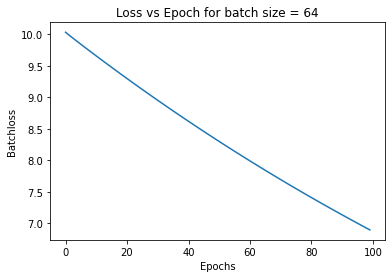

In [ ]:
plt.plot(epoch, bt_loss)
plt.xlabel('Epochs')
plt.ylabel('Batchloss')
plt.title("Loss vs Epoch for batch size = 64")

In [ ]:
train_input, train_target, dev_input, dev_target, test_input = read_data()

print(test_input)
print(net)

[[  39.74101   15.36065    8.31249 ...    1.27488  424.14859   21.03857]
 [  38.01087  -58.38573  -57.76662 ...   75.99168   84.6795   -34.72883]
 [  36.94025 -101.4874    34.19856 ...   -2.039    -78.53343    2.14682]
 ...
 [  35.57222  -33.67729   -9.54801 ...   -2.18869  111.36082    5.32812]
 [  47.61959    5.5825    26.91684 ...    9.32908   47.60612   -7.99566]
 [  42.01372   77.59201  -16.88436 ...   18.23418 -127.31246  -11.23811]]


In [ ]:
test_preds = test_preds*2010

In [ ]:
print(test_preds[0])

[0.]
